In [1]:
import sys, os

import warnings
warnings.filterwarnings('ignore')

# Usual Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split

# Librosa (the mother of audio files)
import librosa
import librosa.display
import IPython.display as ipd

from PIL import Image
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D,UpSampling2D,Dropout,Dense,Flatten,Conv2DTranspose,BatchNormalization,LeakyReLU,Reshape,ZeroPadding2D,Input,Activation
import tensorflow as tf

## Loading and pre-processing audio data:

In [2]:
general_songs_path = r'C:\Users\weldl\Datasets\gtzan-dataset-music-genre-classification'
genres_list = os.listdir(f'{general_songs_path}/genres_original/')
print(genres_list)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [3]:
all_songs = []
for genre in genres_list:
    for song_name in os.listdir(os.path.join(f'{general_songs_path}/genres_original/', genre)):
        all_songs.append(os.path.join(f'{general_songs_path}/genres_original/', genre, song_name))
print('all_songs:', len(all_songs))

all_songs: 1000


In [4]:
def get_spectogram_data(songs_array):
    spec_array = []
    for song_name in songs_array:
        y, sr = librosa.load(song_name)
        y, _ = librosa.effects.trim(y)
        S = librosa.feature.melspectrogram(y, sr=sr)
        S_DB = (librosa.amplitude_to_db(S, ref=np.max)+80)/80
        try:
            spec_array.append(S_DB[:, 0:1210].reshape((128, 1210, 1)))
        except ValueError:
            print(S_DB.shape)
    return np.array(spec_array)

spec_data = get_spectogram_data(all_songs[:])
print(spec_data[0].min(), spec_data[0].max())
spec_data.shape

-0.0 1.0


(1000, 128, 1210, 1)

In [5]:
SPEC_SHAPE = spec_data.shape[1:]

In [6]:
spec_data_train, spec_data_test = train_test_split(spec_data, test_size=0.1, random_state=42)

print('train samples:', spec_data_train.shape)
print('test samples:', spec_data_test.shape)

train samples: (900, 128, 1210, 1)
test samples: (100, 128, 1210, 1)


## Loading and pre-processing images:

In [7]:
general_imgs_path = r'C:\Users\weldl\Datasets\Album Covers Images'
for dirname, _, filenames in os.walk(general_imgs_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

C:\Users\weldl\Datasets\Album Covers Images\0.jpg
C:\Users\weldl\Datasets\Album Covers Images\1.jpg
C:\Users\weldl\Datasets\Album Covers Images\10.jpg
C:\Users\weldl\Datasets\Album Covers Images\100.jpg
C:\Users\weldl\Datasets\Album Covers Images\1000.jpg
C:\Users\weldl\Datasets\Album Covers Images\10000.jpg
C:\Users\weldl\Datasets\Album Covers Images\10001.jpg
C:\Users\weldl\Datasets\Album Covers Images\10002.jpg
C:\Users\weldl\Datasets\Album Covers Images\10003.jpg
C:\Users\weldl\Datasets\Album Covers Images\10004.jpg
C:\Users\weldl\Datasets\Album Covers Images\10005.jpg
C:\Users\weldl\Datasets\Album Covers Images\10006.jpg
C:\Users\weldl\Datasets\Album Covers Images\10007.jpg
C:\Users\weldl\Datasets\Album Covers Images\10008.jpg
C:\Users\weldl\Datasets\Album Covers Images\10009.jpg
C:\Users\weldl\Datasets\Album Covers Images\1001.jpg
C:\Users\weldl\Datasets\Album Covers Images\10010.jpg
C:\Users\weldl\Datasets\Album Covers Images\10011.jpg
C:\Users\weldl\Datasets\Album Covers Images

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



C:\Users\weldl\Datasets\Album Covers Images\61890.jpg
C:\Users\weldl\Datasets\Album Covers Images\61891.jpg
C:\Users\weldl\Datasets\Album Covers Images\61892.jpg
C:\Users\weldl\Datasets\Album Covers Images\61893.jpg
C:\Users\weldl\Datasets\Album Covers Images\61894.jpg
C:\Users\weldl\Datasets\Album Covers Images\61895.jpg
C:\Users\weldl\Datasets\Album Covers Images\61896.jpg
C:\Users\weldl\Datasets\Album Covers Images\61897.jpg
C:\Users\weldl\Datasets\Album Covers Images\61898.jpg
C:\Users\weldl\Datasets\Album Covers Images\61899.jpg
C:\Users\weldl\Datasets\Album Covers Images\619.jpg
C:\Users\weldl\Datasets\Album Covers Images\6190.jpg
C:\Users\weldl\Datasets\Album Covers Images\61900.jpg
C:\Users\weldl\Datasets\Album Covers Images\61901.jpg
C:\Users\weldl\Datasets\Album Covers Images\61902.jpg
C:\Users\weldl\Datasets\Album Covers Images\61903.jpg
C:\Users\weldl\Datasets\Album Covers Images\61904.jpg
C:\Users\weldl\Datasets\Album Covers Images\61905.jpg
C:\Users\weldl\Datasets\Album C

In [8]:
imgs_paths = []
for path in os.listdir(general_imgs_path):
    if '.jpg' in path:
        imgs_paths.append(os.path.join(general_imgs_path, path))

In [9]:
imgs_paths_train = imgs_paths[0:10000]
len(imgs_paths_train)

30000

In [10]:
IMG_SHAPE = (64, 64)

# crop = (30, 55, 150, 175) #croping size for the image so that only the face at centre is obtained
# images = [np.array((Image.open(path).crop(crop)).resize((64,64))) for path in new_path]
images = [np.array(Image.open(path).resize(IMG_SHAPE)) for path in imgs_paths_train]

for i in range(len(images)):
#     images[i] = ((images[i] - images[i].min())/(255 - images[i].min()))
    images[i] = ((images[i] - 127.5)/127.5)
    #images[i] = images[i]*2-1  #uncomment this if activation is tanh for generator last layer

images = np.array(images)
print(images.min(), images.max())

-1.0 1.0


In [11]:
train_data=images
train_data.shape

(30000, 64, 64, 3)

In [12]:
IMG_SHAPE = train_data.shape[1:]
IMG_SHAPE

(64, 64, 3)

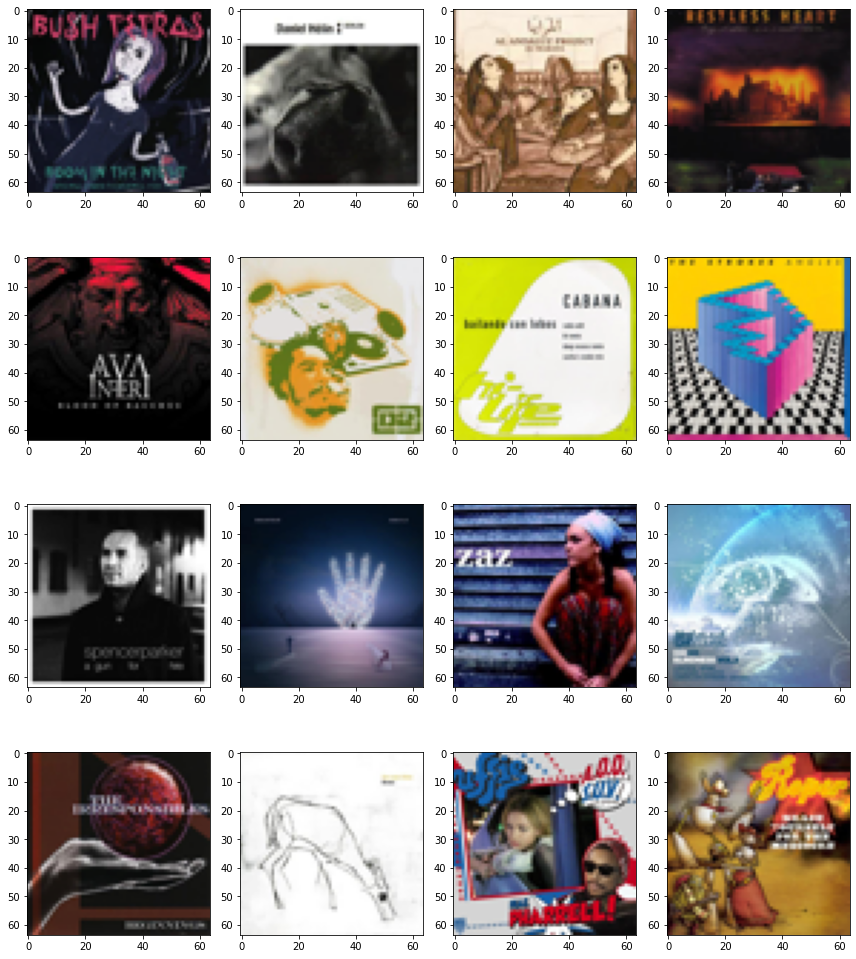

In [13]:
# Images Visualization:
   
def plot_img_samples(img_array, figsize=(12, 14), title=None, subplot_dim=(4, 4)):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    idx=0
    for i in range(subplot_dim[0]):
        for j in range(subplot_dim[1]):
                plt.subplot(subplot_dim[0], subplot_dim[1], i*4 + j +1)
                img_array_ = (img_array[idx]+1) * 127.5
                plt.imshow(img_array_.astype(int))
                idx+=1
    plt.tight_layout()
    plt.show()

plot_img_samples(train_data)

In [14]:
X_train = train_data
X_train.shape

(30000, 64, 64, 3)

# **Generator**

In [15]:
noise_shape = 100

In [16]:
def make_encoder_model(input_shape=(64,64, 3), output_len=100):
    encoder = Sequential()
    encoder.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    encoder.add(Dropout(0.2))
    encoder.add(Conv2D(32, (3,3), strides=(2, 2), padding='same'))
    encoder.add(Dropout(0.2))
    encoder.add(Conv2D(16, (3,3), strides=(2, 2), padding='same'))
    encoder.add(Flatten())
    encoder.add(Dropout(0.2))
    encoder.add(Dense(output_len))
    encoder.add(LeakyReLU(alpha=0.2))
    return encoder

encoder = make_encoder_model(input_shape=SPEC_SHAPE, output_len=noise_shape)
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 605, 32)       320       
_________________________________________________________________
dropout (Dropout)            (None, 64, 605, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 303, 32)       9248      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 303, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 152, 16)       4624      
_________________________________________________________________
flatten (Flatten)            (None, 38912)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 38912)             0

In [17]:
samples = np.array(encoder(spec_data[0:2]))
print(samples.min(), samples.max())

-0.16276905 0.9303963


In [18]:
def build_generator(noise_size, channels):
    GENERATE_RES=2
    model = Sequential()
    model.add(Dense(4 * 4 * 256, activation="relu",       input_dim=noise_size))
    model.add(Reshape((4, 4, 256)))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    for i in range(GENERATE_RES):
         model.add(UpSampling2D())
         model.add(Conv2D(256, kernel_size=3, padding="same"))
         model.add(BatchNormalization(momentum=0.8))
         model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation('tanh'))
    
    return model

generator_ = build_generator(noise_shape, channels=IMG_SHAPE[-1])
generator_.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)         590080    
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 256)         1024      
_________________________________________________________________
activation (Activation)      (None, 8, 8, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 256)      

In [19]:
# Adding the encoder to the model:
generator = Sequential([encoder, generator_])
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 100)               3905492   
_________________________________________________________________
sequential_1 (Sequential)    (None, 64, 64, 3)         2785027   
Total params: 6,690,519
Trainable params: 6,688,471
Non-trainable params: 2,048
_________________________________________________________________


# **Discriminator**

In [20]:
def build_discriminator(input_shape):
    model = Sequential()
#     model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.4))
    model.add(Conv2D(32, (3,3), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

discriminator = build_discriminator(IMG_SHAPE)
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 32769     
Total params: 33,665
Trainable params: 33,665
Non-trainable params: 0
_________________________________________________________________


# **DCGAN (combined model)**

In [21]:
GAN = Sequential([generator,discriminator])

In [22]:
discriminator.compile(optimizer='adam',loss='binary_crossentropy')
discriminator.trainable = False

In [23]:
GAN.compile(optimizer='adam',loss='binary_crossentropy')

In [24]:
GAN.layers

In [25]:
GAN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 64, 3)         6690519   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 33665     
Total params: 6,724,184
Trainable params: 6,688,471
Non-trainable params: 35,713
_________________________________________________________________


# **Training**

In [26]:
epochs = 100  #set epoch according to your training dataset size,i had chosen 50k images hence epochs are high as 300...
batch_size = 64

In [27]:
D_loss=[] #list to collect loss for the discriminator model
G_loss=[] #list to collect loss for generator model

Currently on Epoch 1
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468


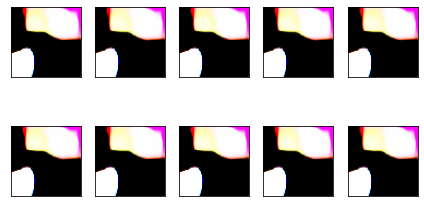

Epoch: 1,  Loss: D_real = 0.119, D_fake = 0.366,  G = 1.910
Currently on Epoch 2
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 2,  Loss: D_real = 1.021, D_fake = 0.077,  G = 0.489
Currently on Epoch 3
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 3,  Loss: D_real = 1.131, D_fake = 0.214,  G = 3.034
Currently on Epoch 4
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 4,  Loss: D_real = 6.508, D_fake = 0.772,  G = 2.818
Currently on Epoch 5
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468


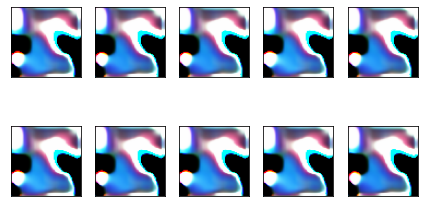

Epoch: 6,  Loss: D_real = 1.468, D_fake = 0.070,  G = 1.856
Currently on Epoch 7
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 7,  Loss: D_real = 1.729, D_fake = 0.420,  G = 0.565
Currently on Epoch 8
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 8,  Loss: D_real = 0.764, D_fake = 0.586,  G = 0.767
Currently on Epoch 9
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 9,  Loss: D_real = 5.177, D_fake = 0.893,  G = 4.014
Currently on Epoch 10
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468

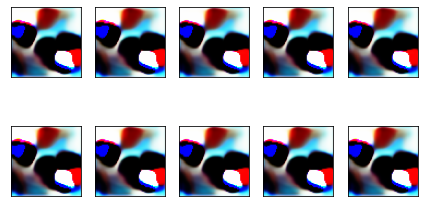

Epoch: 11,  Loss: D_real = 1.329, D_fake = 0.382,  G = 2.991
Currently on Epoch 12
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 12,  Loss: D_real = 1.114, D_fake = 0.218,  G = 1.170
Currently on Epoch 13
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 13,  Loss: D_real = 1.148, D_fake = 0.228,  G = 2.226
Currently on Epoch 14
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 14,  Loss: D_real = 0.383, D_fake = 0.111,  G = 3.659
Currently on Epoch 15
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

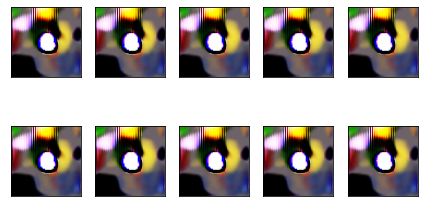

Epoch: 16,  Loss: D_real = 0.802, D_fake = 0.399,  G = 2.816
Currently on Epoch 17
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 17,  Loss: D_real = 1.820, D_fake = 1.214,  G = 3.469
Currently on Epoch 18
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 18,  Loss: D_real = 2.750, D_fake = 1.357,  G = 7.731
Currently on Epoch 19
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 19,  Loss: D_real = 0.301, D_fake = 0.156,  G = 4.625
Currently on Epoch 20
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

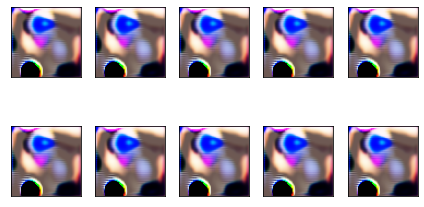

Epoch: 21,  Loss: D_real = 0.819, D_fake = 0.098,  G = 3.154
Currently on Epoch 22
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 22,  Loss: D_real = 1.257, D_fake = 0.480,  G = 1.473
Currently on Epoch 23
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 23,  Loss: D_real = 1.388, D_fake = 1.424,  G = 1.323
Currently on Epoch 24
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 24,  Loss: D_real = 1.368, D_fake = 0.304,  G = 6.654
Currently on Epoch 25
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

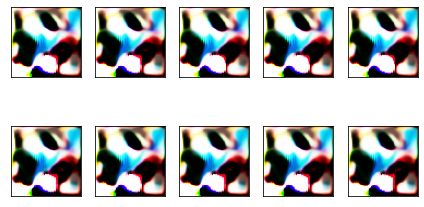

Epoch: 26,  Loss: D_real = 1.269, D_fake = 0.751,  G = 2.176
Currently on Epoch 27
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 27,  Loss: D_real = 1.996, D_fake = 0.235,  G = 5.000
Currently on Epoch 28
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 28,  Loss: D_real = 3.472, D_fake = 0.409,  G = 5.332
Currently on Epoch 29
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 29,  Loss: D_real = 1.469, D_fake = 0.706,  G = 2.195
Currently on Epoch 30
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

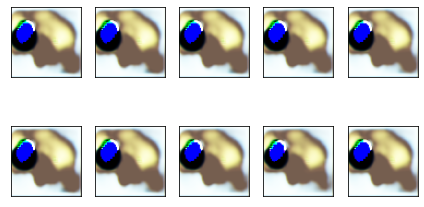

Epoch: 31,  Loss: D_real = 0.779, D_fake = 0.653,  G = 3.676
Currently on Epoch 32
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 32,  Loss: D_real = 7.640, D_fake = 0.897,  G = 3.073
Currently on Epoch 33
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 33,  Loss: D_real = 1.087, D_fake = 0.469,  G = 1.601
Currently on Epoch 34
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 34,  Loss: D_real = 3.142, D_fake = 0.517,  G = 1.621
Currently on Epoch 35
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

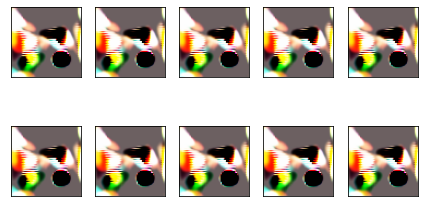

Epoch: 36,  Loss: D_real = 2.361, D_fake = 0.680,  G = 3.199
Currently on Epoch 37
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 37,  Loss: D_real = 9.587, D_fake = 2.797,  G = 2.143
Currently on Epoch 38
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 38,  Loss: D_real = 0.411, D_fake = 0.405,  G = 3.707
Currently on Epoch 39
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 39,  Loss: D_real = 1.288, D_fake = 0.296,  G = 7.597
Currently on Epoch 40
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

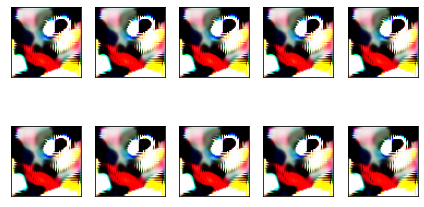

Epoch: 41,  Loss: D_real = 1.511, D_fake = 0.238,  G = 5.760
Currently on Epoch 42
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 42,  Loss: D_real = 4.744, D_fake = 2.250,  G = 4.586
Currently on Epoch 43
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 43,  Loss: D_real = 9.379, D_fake = 0.633,  G = 5.814
Currently on Epoch 44
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 44,  Loss: D_real = 1.461, D_fake = 0.920,  G = 3.835
Currently on Epoch 45
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

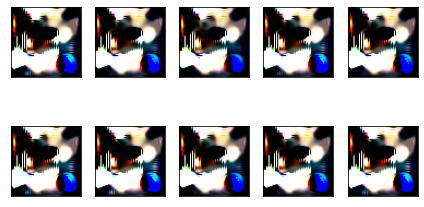

Epoch: 46,  Loss: D_real = 1.843, D_fake = 0.767,  G = 6.174
Currently on Epoch 47
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 47,  Loss: D_real = 1.869, D_fake = 0.888,  G = 3.003
Currently on Epoch 48
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 48,  Loss: D_real = 1.262, D_fake = 0.595,  G = 3.082
Currently on Epoch 49
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 49,  Loss: D_real = 1.029, D_fake = 0.599,  G = 1.459
Currently on Epoch 50
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

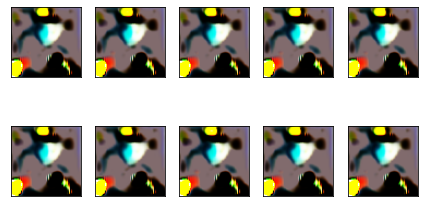

Epoch: 51,  Loss: D_real = 0.403, D_fake = 0.955,  G = 5.659
Currently on Epoch 52
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 52,  Loss: D_real = 2.713, D_fake = 0.487,  G = 3.051
Currently on Epoch 53
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 53,  Loss: D_real = 1.063, D_fake = 0.238,  G = 5.618
Currently on Epoch 54
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200 of 468
	Currently on batch number 300 of 468
	Currently on batch number 400 of 468
Epoch: 54,  Loss: D_real = 1.819, D_fake = 0.325,  G = 4.626
Currently on Epoch 55
	Currently on batch number 0 of 468
	Currently on batch number 100 of 468
	Currently on batch number 200

KeyboardInterrupt: 

In [28]:
with tf.device('/gpu:0'):
 for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    
    # For every batch in the dataset
    for i in range(X_train.shape[0]//batch_size):
        
        if (i)%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(X_train)//batch_size}")
            
#         noise = np.random.uniform(-1,1,size=[batch_size,noise_shape])
        idxs = np.array([i for i in range(spec_data_train.shape[0])])
        idxs_select = np.random.choice(idxs, batch_size)
        noise = spec_data_train[idxs_select]

        gen_image = generator.predict_on_batch(noise)
        
        train_dataset = X_train[i*batch_size:(i+1)*batch_size]
        #train on real image
        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = True
        d_loss1 = discriminator.train_on_batch(train_dataset,train_label)
        
        #train on fake image
        train_label=np.zeros(shape=(batch_size,1))
        d_loss2 = discriminator.train_on_batch(gen_image,train_label)
        
#         noise=np.random.uniform(-1,1,size=[batch_size,noise_shape])
        idxs = np.array([i for i in range(spec_data_train.shape[0])])
        idxs_select = np.random.choice(idxs, batch_size)
        noise = spec_data_train[idxs_select]

        train_label=np.ones(shape=(batch_size,1))
        discriminator.trainable = False
        #train the generator
        g_loss = GAN.train_on_batch(noise, train_label)
        D_loss.append(d_loss1+d_loss2)
        G_loss.append(g_loss)
        
         
    if epoch % 5 == 0:
        samples = 10
#         test_samples = np.random.normal(loc=0, scale=1, size=(samples,100))        
        idxs = np.array([i for i in range(spec_data_test.shape[0])])
        idxs_select = np.random.choice(idxs, samples)
        test_samples = spec_data_test[idxs_select]
        x_fake = generator.predict(test_samples)

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            img_array_ = (x_fake[k]+1) * 127.5
            plt.imshow(img_array_.astype(int))
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()

    print('Epoch: %d,  Loss: D_real = %.3f, D_fake = %.3f,  G = %.3f' %   (epoch+1, d_loss1, d_loss2, g_loss))        
print('Training is complete')

# **Output Visualization**

In [29]:
noise = spec_data_test

In [30]:
im=generator.predict(noise)

In [31]:
im.shape[0]

100

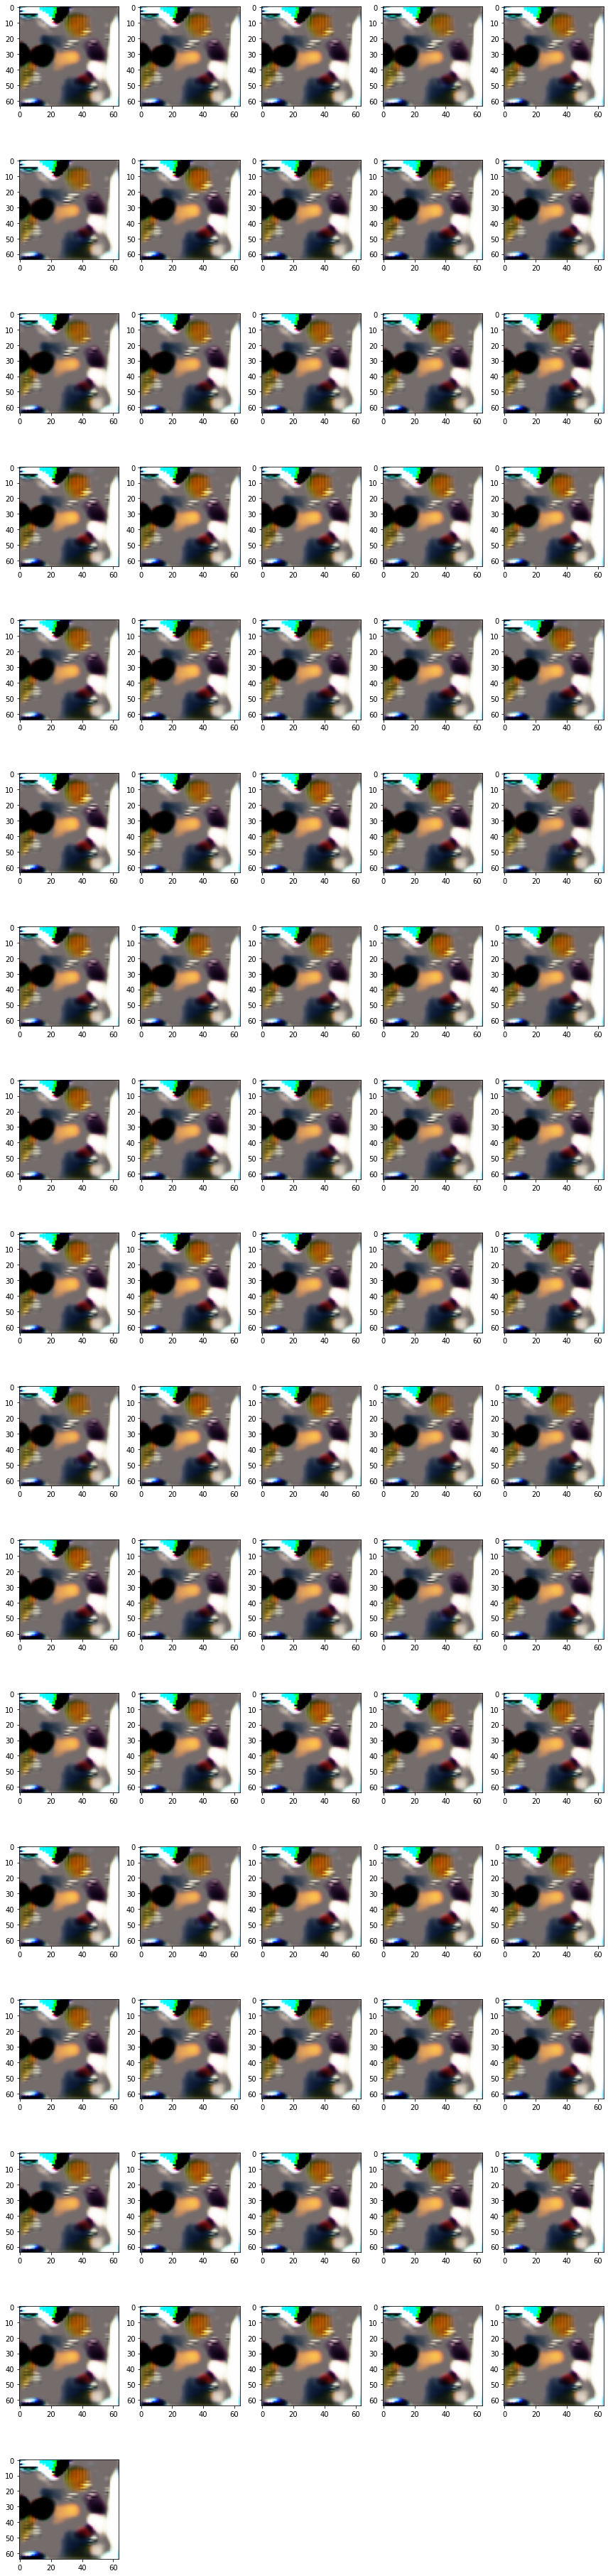

In [32]:
plot_img_samples(im, subplot_dim=(20, 5), figsize=(12, 60))

# **Loss Curve**

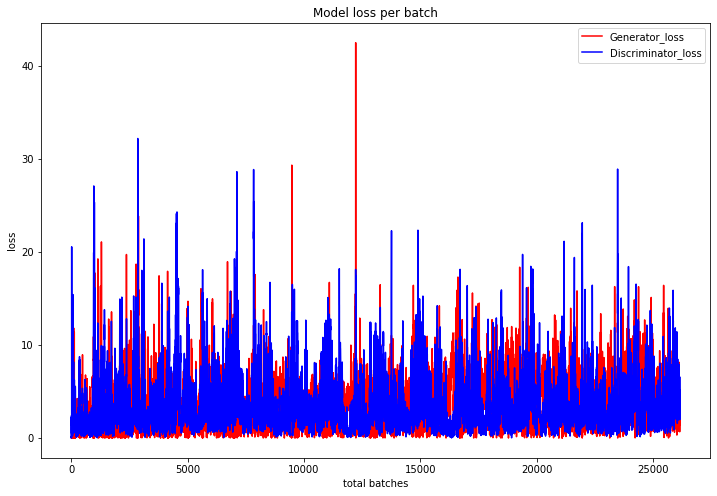

In [33]:
plt.figure(figsize=(12, 8))
plt.plot(G_loss,color='red',label='Generator_loss')
plt.plot(D_loss,color='blue',label='Discriminator_loss')
plt.legend()
plt.xlabel('total batches')
plt.ylabel('loss')
plt.title('Model loss per batch')
plt.show()